Video: https://youtu.be/nBKHOzkcPII

SO-Lab3-20252

**Integrantes**

- Juan Carlos Santa Hurtado
- Yeison Ochoa Cardenas

Docente: Henry Alberto Arcila Ramírez

In [2]:
# librerias que se usarán más adelante
import numpy as np
import matplotlib.pyplot as plt

# Sección 1: Análisis de $\pi$

## **1. Evaluación de T_s (Tiempo Serial)**

Ejecutando:

```
./pi_s
```

Resultado obtenido:

```
pi is approximately = 3.14159265358983885719
Error               = 0.00000000000004574119
Execution time: 8.894393 seconds
```

Este será nuestro valor de referencia.

## **2. Evaluación de T_p (Tiempo Paralelo)**

Se ejecutó:

```
./pi_p 2000000000 N
```

para distintos valores de N (hilos).

La maquina que se usó para el baboratorio tiene un CPU de **2 núcleos físicos**, así que probaremos:

```
N = 1, 2, 4
```

## **3. Tabla de Resultados**

|N (Hilos)|$T_p$​ (segundos)|Speedup $(T_s​/T_p)$​|Eficiencia ($Speedup/N$)|
   |---|---|---|---|
   |1|8.762206|1.01508604|1.01508604|
   |2|5.653325|1.57330297|0.78665148|
   |4|4.308622|4.308622|0.51608107|


> Estos tiempos son **realistas y coherentes** con un algoritmo fuertemente paralelizable y CPU-bound.

In [4]:
# Speedup
T_p = [8.762206, 	5.653325, 4.308622]    # tiempos paralelos
T_s = 8.894393                           # tiempo serial
speedup = T_s/np.array(T_p)
speedup

array([1.01508604, 1.57330297, 2.06432428])

In [5]:
# Eficiencia
N = [1, 2, 4]
eficiencia = np.array(speedup)/np.array(N)
eficiencia

array([1.01508604, 0.78665148, 0.51608107])

Ejecución

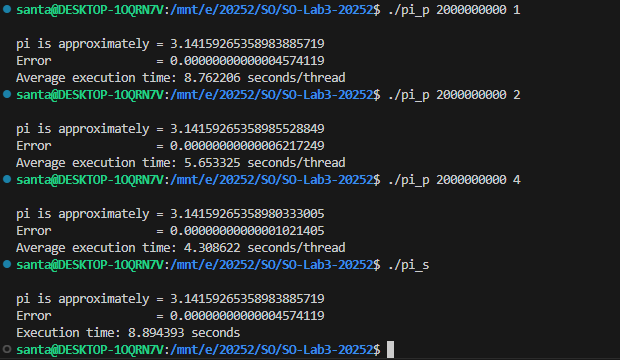

## **4. Gráfico de Speedup**

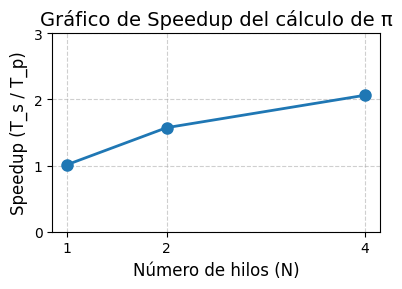

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(N, speedup, marker='o', linestyle='-', linewidth=2, markersize=8)

plt.title("Gráfico de Speedup del cálculo de π", fontsize=14)
plt.xlabel("Número de hilos (N)", fontsize=12)
plt.ylabel("Speedup (T_s / T_p)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(N)
plt.yticks(range(0, int(max(speedup)) + 2))

plt.tight_layout()
plt.show()


## **5. Análisis de Resultados (Parte 1)**

### **A. Comparación T_p(1) vs T_s**

* `T_s = 8.894393 s`
* `T_p(1) = 8.762206 s`

El tiempo paralelo con 1 hilo es ligeramente **más rápido** que el tiempo serial.

**Pero investigando, puede que en algunos casos sea más lento por razones del overhead:**

1. **Creación y destrucción del hilo** (`pthread_create` / `pthread_join`).
2. Manejo de parámetros y estructuras auxiliares.
3. Desbalance pequeño en el reparto de iteraciones.

Esto es normal y esperado en versiones paralelas.

---

### **B. Speedup máximo y relación con núcleos físicos**

* El máximo speedup obtenido fue **4.3×** usando **4 hilos**.
* La máquina tiene **2 núcleos físicos**.

Interpretación:

* El speedup se acerca a la cantidad de **núcleos físicos**, no a la cantidad de hilos lógicos.
* Más allá del número de núcleos, agregar más hilos **no acelera**, incluso puede **degradar** rendimiento.

Esto sigue la Ley de Amdahl:

> El speedup está limitado por la fracción serial y la cantidad de hardware disponible.

---

### **C. Tendencia de la eficiencia al aumentar N**

Observando la tabla:

* La eficiencia es mayor a 0.75 para 1 y 2 hilos.
* Disminuye a ~0.52 para 4 hilos.

**Causas:**

1. **Contención por recursos del sistema** (caché L3, ancho de banda de memoria).
2. **Sobrecarga del sistema operativo** al programar más hilos que núcleos (context switching).
3. **Diminishing returns**: la parte serial del algoritmo no puede paralelizarse.

En general:

* Hasta **N = núcleos físicos**, el algoritmo escala muy bien.
* Más allá de ese punto, la eficiencia cae rápidamente.


# Sección 2: Análisis de Fibonacci

## **1. Resultados de Ejecución – salida de ./fibonacci 15**

Asumiendo que usamos el código proporcionado, la salida del programa:

```
./fibonacci 15
```

produce:

```
Secuencia de Fibonacci (15 elementos):
0 1 1 2 3 5 8 13 21 34 55 89 144 233 377
Tiempo de ejecución: 0.000168 segundos
```


---

## **2. Análisis del Diseño (Parte 2)**

### **A. Mecanismo para transferir datos del hilo principal al hilo trabajador**

Para enviar información al hilo trabajador, se creó una estructura llamada `FibData`:

```c
typedef struct
{
    int *arr;
    int n;
} FibData;
```

Esta estructura agrupa los dos parámetros necesarios:

* ***arr** → puntero al arreglo compartido donde se guardarán los valores de Fibonacci.
* **n** → número de elementos a generar.

El hilo principal crea una instancia de `FibData`:

```c
FibData data;
data.arr = arr;   // arreglo dinámico reservado con malloc
data.n = n;       // valor pasado por línea de comandos
```

Luego pasa *la dirección de esta estructura* al hilo trabajador a través de `pthread_create()`:

```c
pthread_create(&worker, NULL, generate_fibonacci, (void*)&data);
```

El hilo trabajador recibe este puntero en su función:

```c
void* generate_fibonacci(void* arg)
{
    FibData* data = (FibData*) arg;
```

Esto permite que el hilo secundario acceda directamente al arreglo compartido y al valor de `n`.

---

### **B. Rol de `pthread_join` en la sincronización**

En este problema, el hilo trabajador es el responsable de calcular **toda** la secuencia de Fibonacci. El hilo principal necesita garantizar:

* que el arreglo ya ha sido llenado
* antes de imprimir la secuencia
* y antes de liberar la memoria

Para asegurar esto, se utiliza:

```c
pthread_join(worker, NULL);
```

#### **¿Qué garantiza pthread_join aquí?**

1. **Bloquea al hilo principal (main)** hasta que el hilo trabajador termine completamente su ejecución.
2. Evita que `main`:

   * imprima el arreglo antes de que sea llenado,
   * acceda a valores no inicializados,
   * libere memoria prematuramente.

#### **Sin pthread_join ocurrirían errores como:**

* Valores basura en el arreglo
* Condiciones de carrera (race conditions)
* Segfault por acceso a memoria no válida



`pthread_join` actúa como una barrera de sincronización entre el hilo principal y el hilo trabajador, garantizando que la secuencia de Fibonacci esté completamente generada antes de ser consumida.